# ANALISI IA CALDAIA CREMA
Intelligenza artificiale in grado di gestire l'accensione e lo spegnimento della caldaia nel condominio di Crema costruzioni.

Verrà fatta un'analisi preliminare sulla correlazione dei dati.

Verrà costruito un regressore che, basandosi su:
1. temperatura esterna
2. data
3. ora
4. temperatura attuale caldaia
5. temperatura attuale solare

andarà a determinare se è necessario accendere la caldaia o meno


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DEFAULT_FIGSIZE = (20,20)

df = pd.read_csv("data/cremaCaldaia (3).csv")
df = df.sort_values(by='timestamp')

In [54]:
df[['date','time']] = df.timestamp.str.split(" ",expand=True)
df['date'] = df['date'].str.replace("-","").astype(int)
df['time'] = df['time'].str.replace(":","").astype(int)
df.head()

,timestamp,T_Esterna,T_Mand_Ca,T_Rit_Cal,T_AcACS_C,T_Mand_So,T_Rit_Sol,T_AcACS_S,T_IngrAFS,T_Man_ACS,...,AFS_VolTot,A1_ACS_VolTot,A2_ACS_VolTot,A3_ACS_VolTot,A4_ACS_VolTot,A5_ACS_VolTot,Cald_SttExt,PRicACS_SttExt,date,time
0,2021-07-27 10:37:25,25.75,41.53,39.12,44.75,34.44,34.22,43.83,25.32,41.32,...,38,42.0,0.2,28.7,4689.2,4,0,0,20210727,103725
1,2021-07-27 10:37:35,25.75,41.53,39.12,44.75,34.44,34.22,43.83,25.32,41.32,...,38,42.0,0.2,28.7,4689.2,4,0,0,20210727,103735
2,2021-07-27 10:37:46,25.75,41.53,39.12,44.75,34.44,34.22,43.83,25.32,41.32,...,38,42.0,0.2,28.7,4689.2,4,0,0,20210727,103746
3,2021-07-27 10:37:56,25.75,41.53,39.12,44.75,34.44,34.22,43.83,25.32,41.32,...,38,42.0,0.2,28.7,4689.2,4,0,0,20210727,103756
4,2021-07-27 10:38:06,25.77,41.53,39.12,44.75,34.44,34.22,43.83,25.32,41.16,...,38,42.0,0.2,28.7,4689.2,4,0,0,20210727,103806


# Struttura delle serie
Primo plot per capire interazione dei dati

<AxesSubplot:>

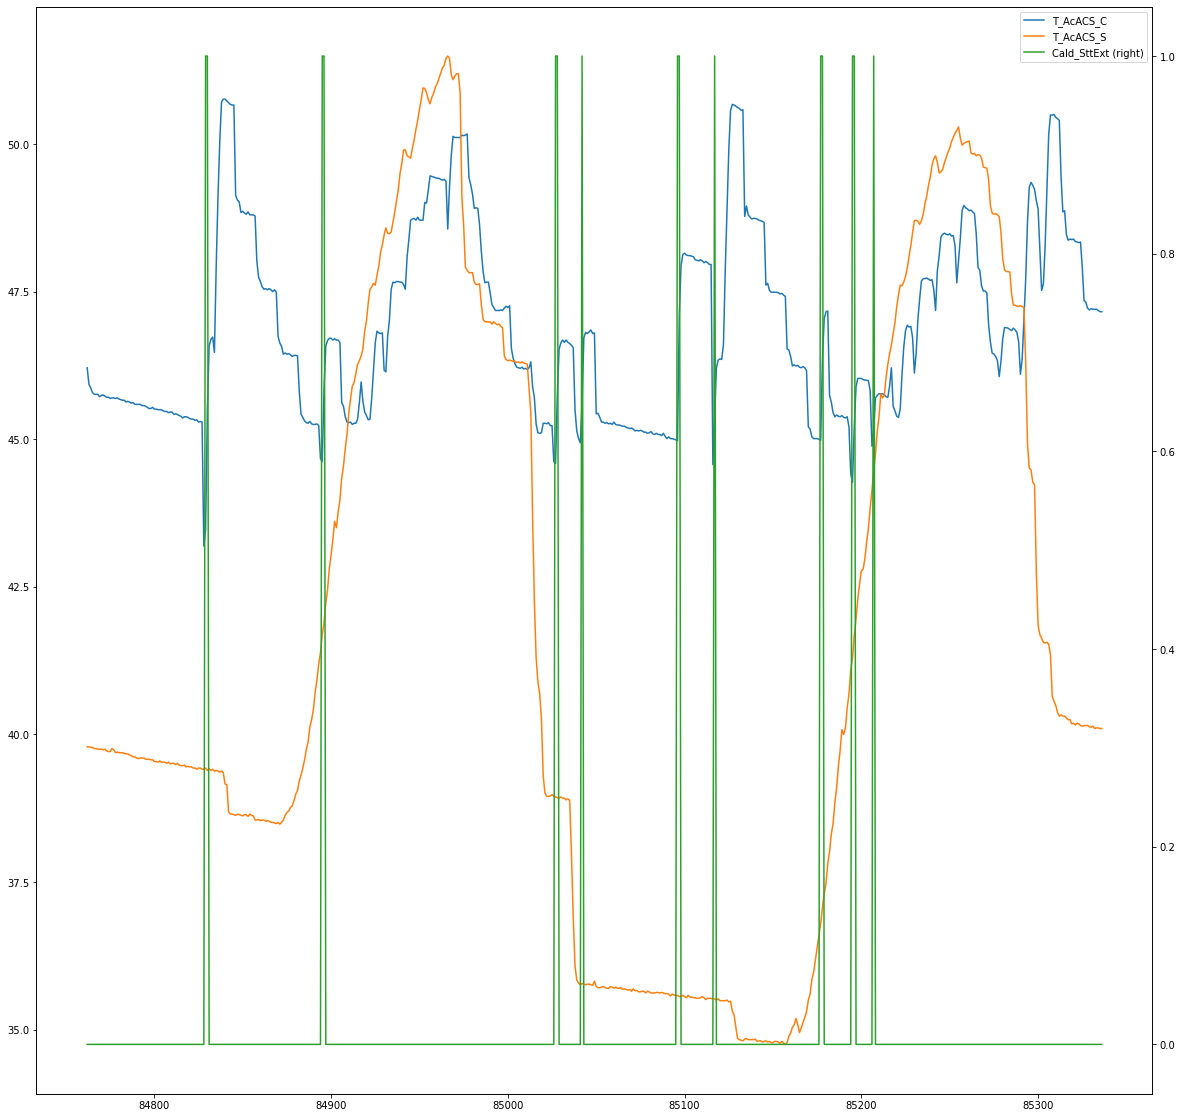

In [59]:
ax = df[(df['date']==20210911) | (df['date']==20210912)][['T_AcACS_C','T_AcACS_S',]].plot(figsize=DEFAULT_FIGSIZE)
df[(df['date']==20210911) | (df['date']==20210912)][['Cald_SttExt']].plot(figsize=DEFAULT_FIGSIZE,secondary_y=True, ax=ax)

#df[['timestamp','T_Esterna','T_Mand_So','T_Rit_Sol','T_AcACS_S']].plot(figsize=DEFAULT_FIGSIZE)
#df[['timestamp','T_Esterna','A1_ACS_VolTot','A2_ACS_VolTot','A3_ACS_VolTot','A5_ACS_VolTot']].plot(figsize=DEFAULT_FIGSIZE)

# ANALISI DEI DATI

## Correlazione dei dati
Analisi della correlazione dei dati per la costruzione del regressore

In [6]:
corr_df = df.corr()

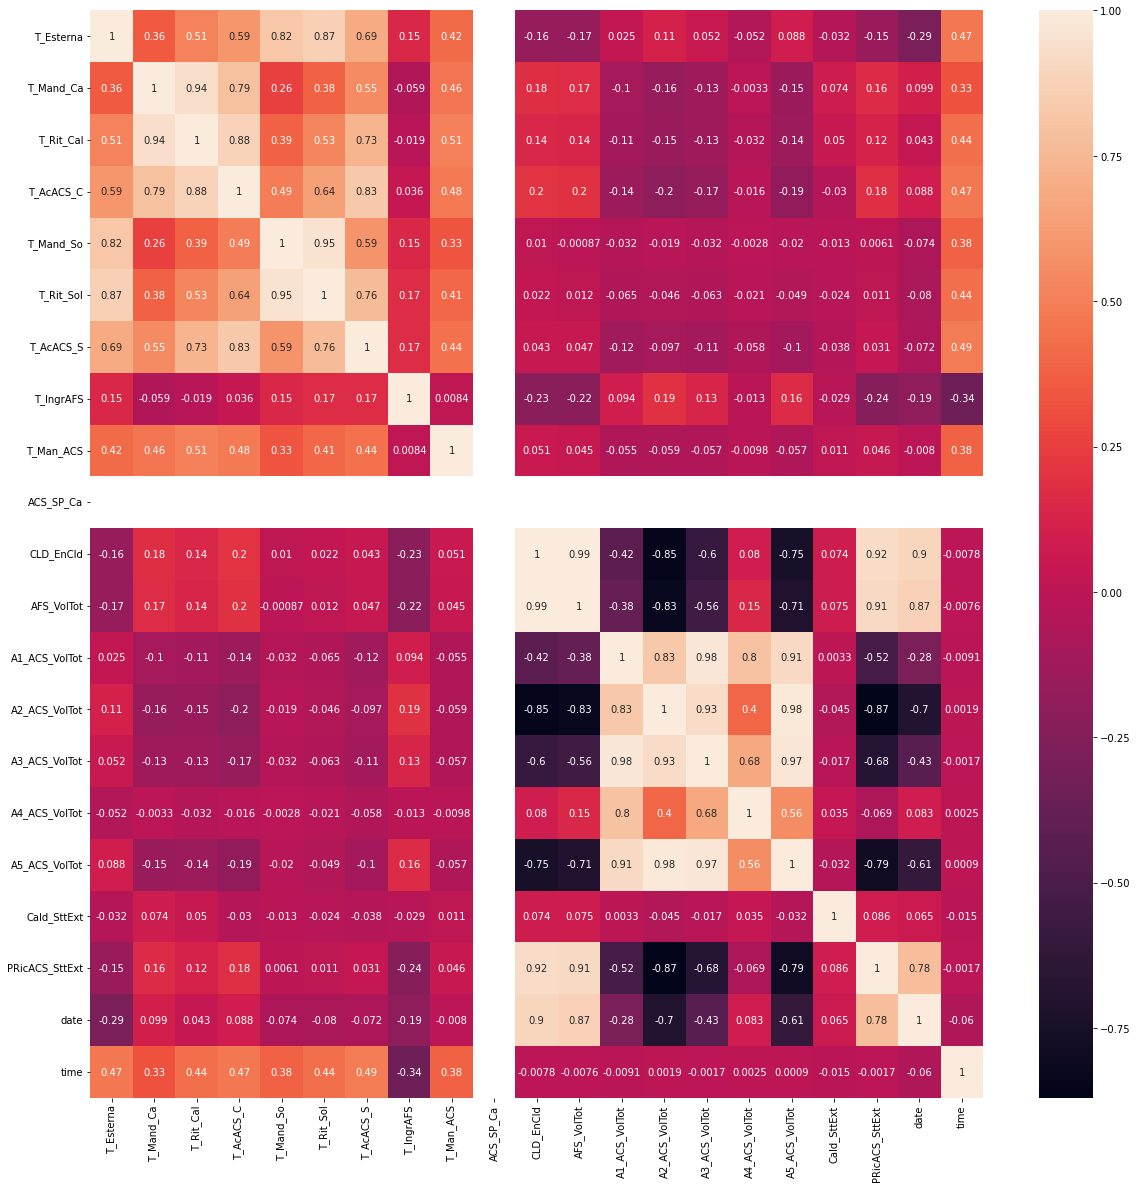

In [7]:
plt.figure(figsize=DEFAULT_FIGSIZE)
sns.heatmap(corr_df, annot=True)
plt.show()

## REGRESSIONE LINEARE
Useremo un regressore lineare per andare a creare una IA in grado di determinare quale sia la corretta temperatura a cui deve stare la caldaia in un dato momento

In [67]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

target = df['T_AcACS_C']
source = df.drop(columns=['timestamp','T_AcACS_C'])

model.fit(source, target)

LinearRegression()

## VALUTAZIONE REGRESSORE
Andiamo ad utilizzare tre metriche principali
1. Mean Squared Error
2. Mean Absolute Error
3. R2

In [68]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2
sample = df.sample()
sample_target = sample['T_AcACS_C']
sample = sample.drop(columns=['timestamp','T_AcACS_C'])
model.predict(sample), sample_target

(array([49.62489787]),
 34712    50.21
 Name: T_AcACS_C, dtype: float64)

In [69]:
prevision = model.predict(source)
mse(target,prevision) , mae(target,prevision) , r2(target,prevision)

(0.9993917165801063, 0.662564898754849, 0.8662104098158995)

# SALVATAGGIO REGRESSORE
Questo regressore lo andremo a salvare su un file che potremo poi usare in un secondo momento.

E' buona pratica scrivere direttamente nel nome del file l'accuracy ottenuta dal modello, in questo caso noi prediligiamo lo score r quadro.

In [63]:
from joblib import dump, load
#dump(model, './models/88_caldaia.joblib') 

Per recuperare il modello basta chiamare la funzione load

In [64]:
model_88 = load('./models/88_caldaia.joblib')
sample = df.sample()
sample_target = sample['T_AcACS_C']
sample = sample.drop(columns=['timestamp','T_AcACS_C'])
model_88.predict(sample), sample_target

(array([47.57353179]),
 81389    47.93
 Name: T_AcACS_C, dtype: float64)

# Resituzione dei dati finali
Di seguito viene mostrato il confronto tra la temperatura prevista dal sistema e quella effettivamente riscontrata

In [71]:
model_88 = load('./models/88_caldaia.joblib')
model_87 = load('./models/87_caldaia.joblib')
df['Predicted88'] = model.predict(source)
#df['Predicted87'] = model_87.predict(source)
df['Minimum'] = 45

<AxesSubplot:>

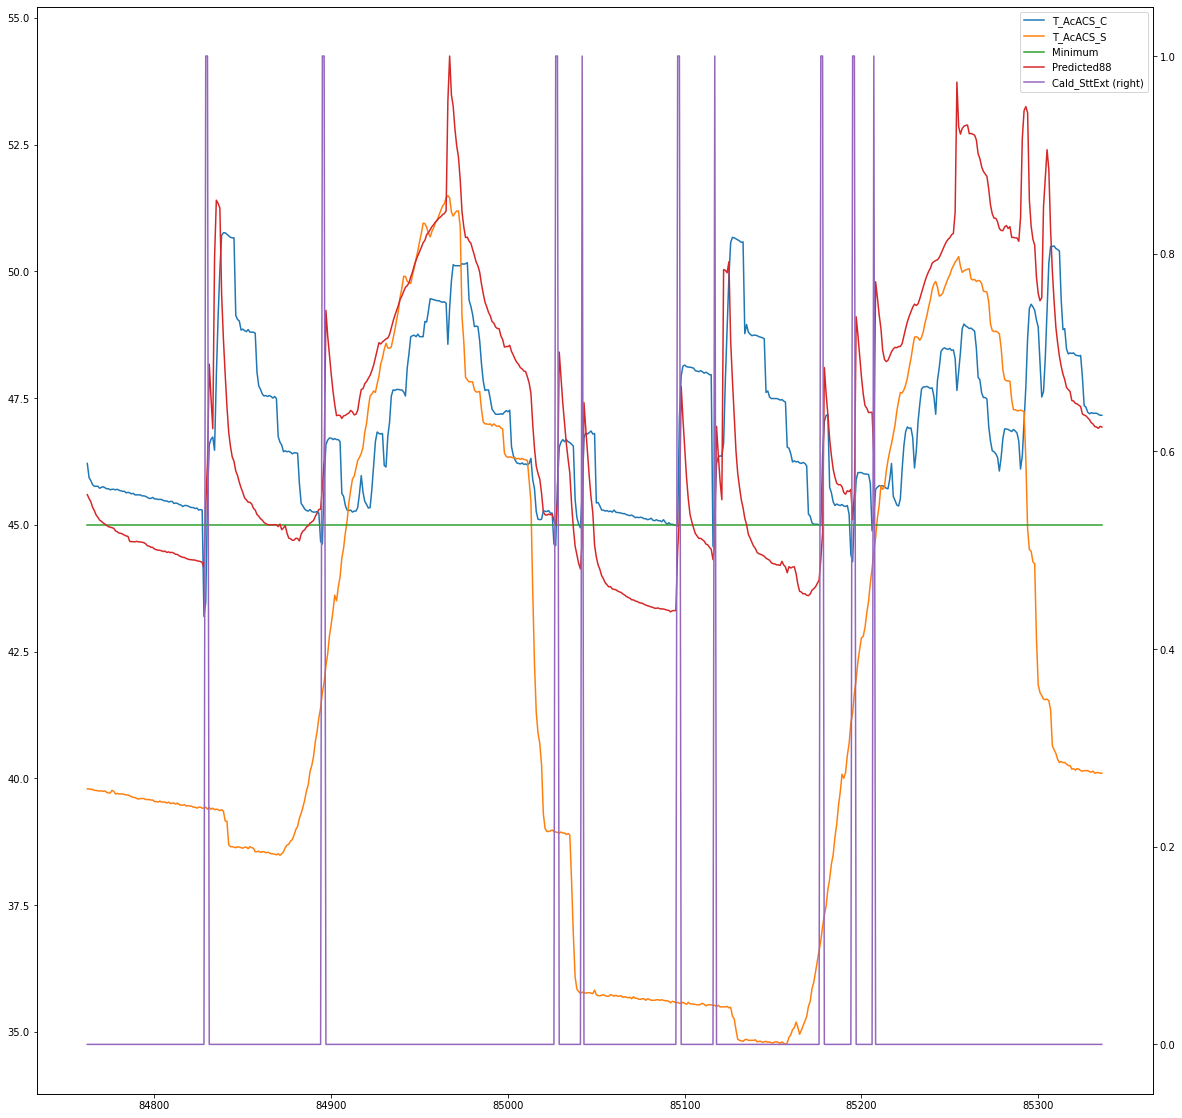

In [72]:
ax = df[(df['date']==20210911) | (df['date']==20210912)][['T_AcACS_C','T_AcACS_S','Minimum','Predicted88']].plot(figsize=DEFAULT_FIGSIZE)
df[(df['date']==20210911) | (df['date']==20210912)][['Cald_SttExt']].plot(figsize=DEFAULT_FIGSIZE,secondary_y=True, ax=ax)
#ax = df[df['date']==20210908][['time','T_AcACS_C','Minimum','Predicted88','T_AcACS_S']].plot("time",figsize=DEFAULT_FIGSIZE)
#df[df['date']==20210908][['time','Cald_SttExt']].plot("time",figsize=DEFAULT_FIGSIZE,secondary_y=True, ax=ax)

<AxesSubplot:xlabel='time'>

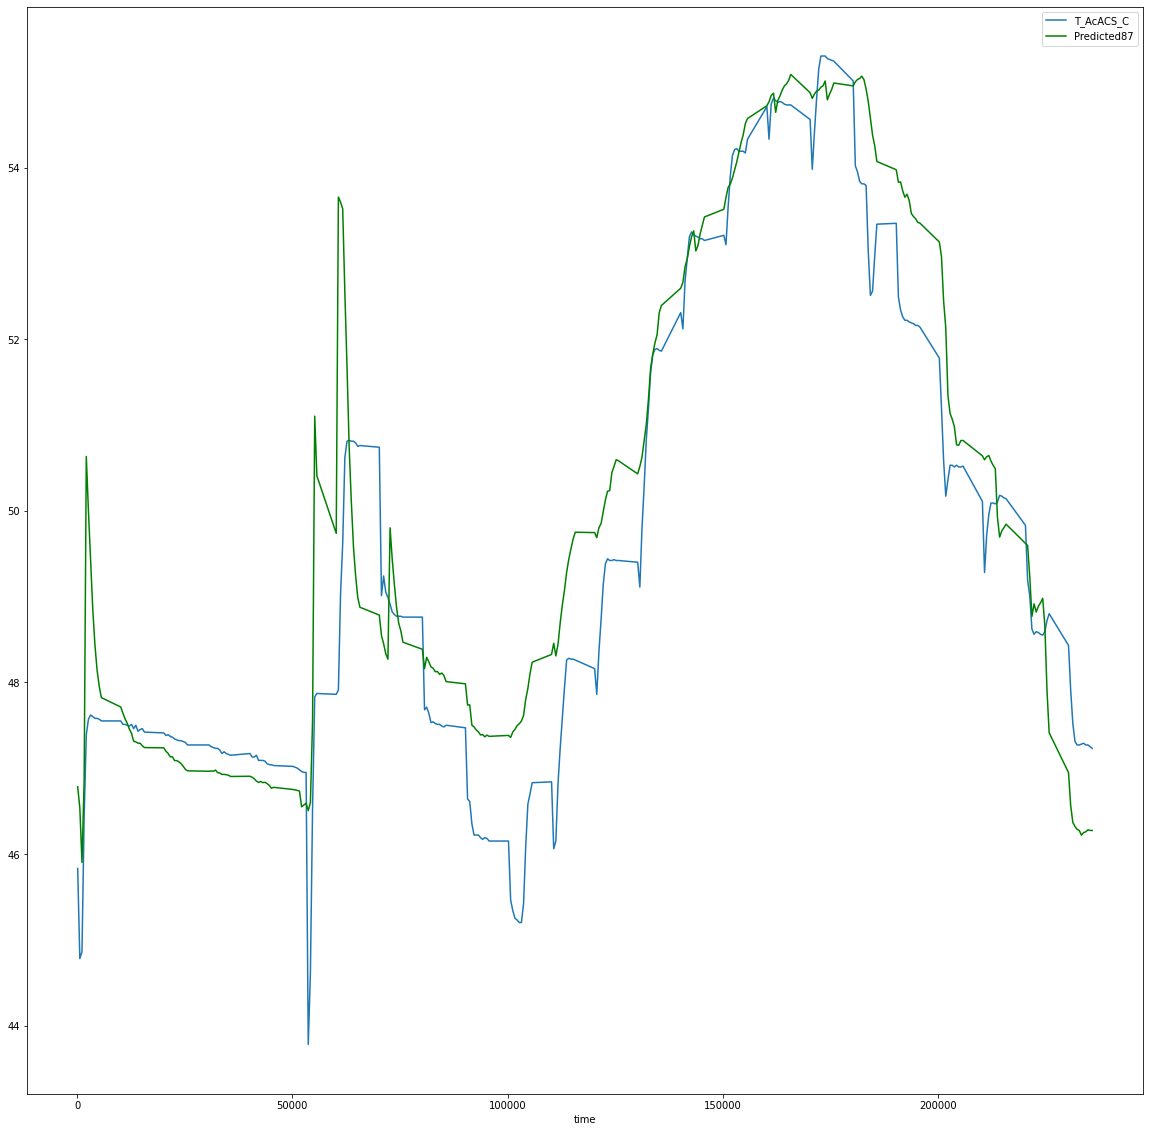

In [52]:

ax = df[df['date']==20210901][['time','T_AcACS_C']].plot("time",figsize=DEFAULT_FIGSIZE)
df[df['date']==20210901][['time','Predicted87']].plot("time",color="g",figsize=DEFAULT_FIGSIZE, ax=ax)

<AxesSubplot:xlabel='time'>

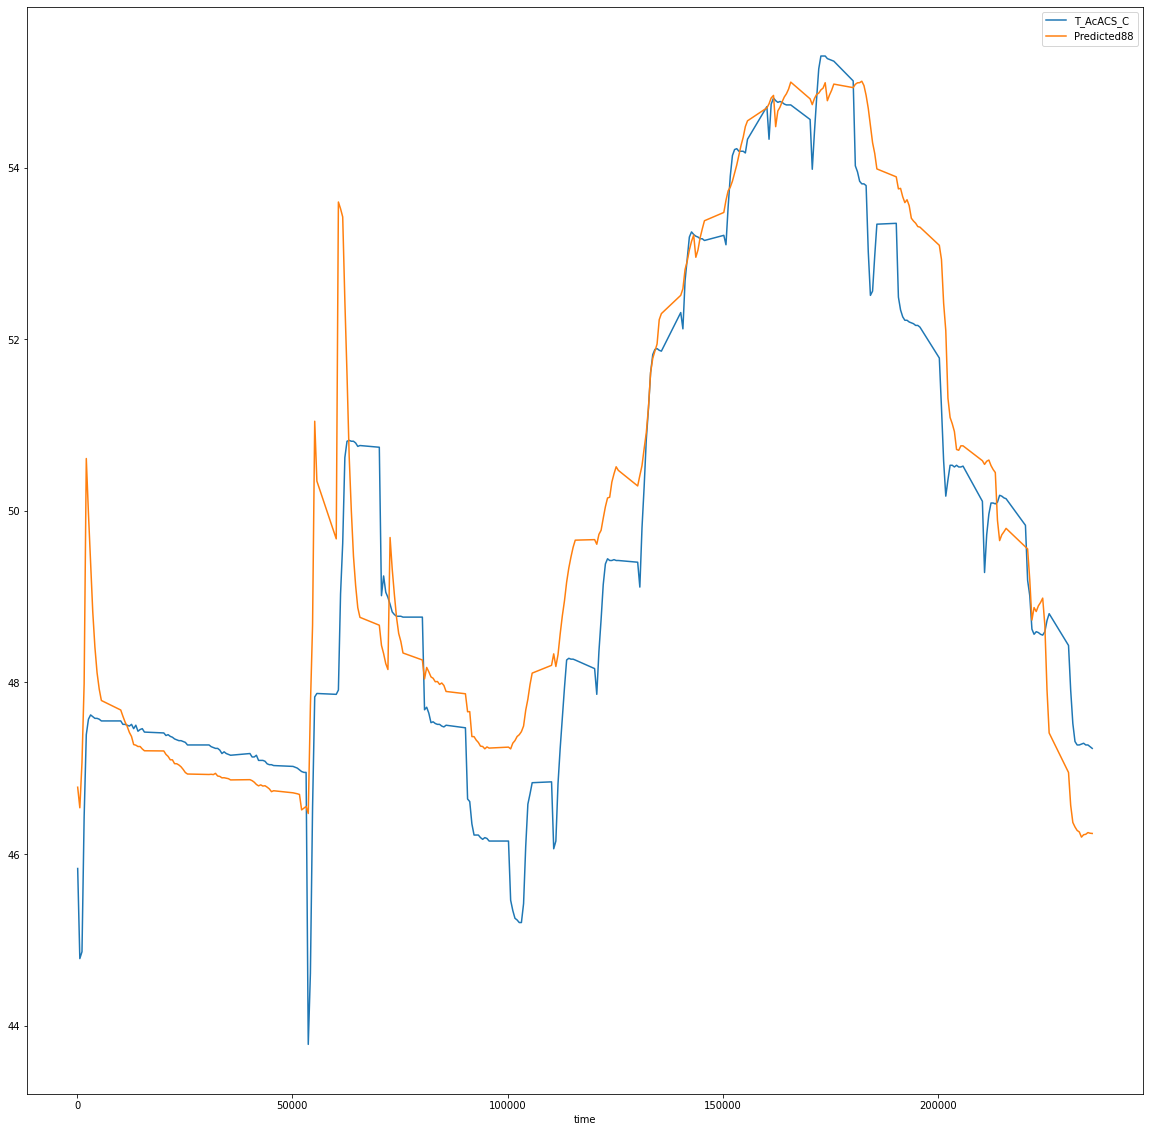

In [49]:

df[df['date']==20210901][['time','T_AcACS_C','Predicted88']].plot("time",figsize=DEFAULT_FIGSIZE)

<AxesSubplot:xlabel='time'>

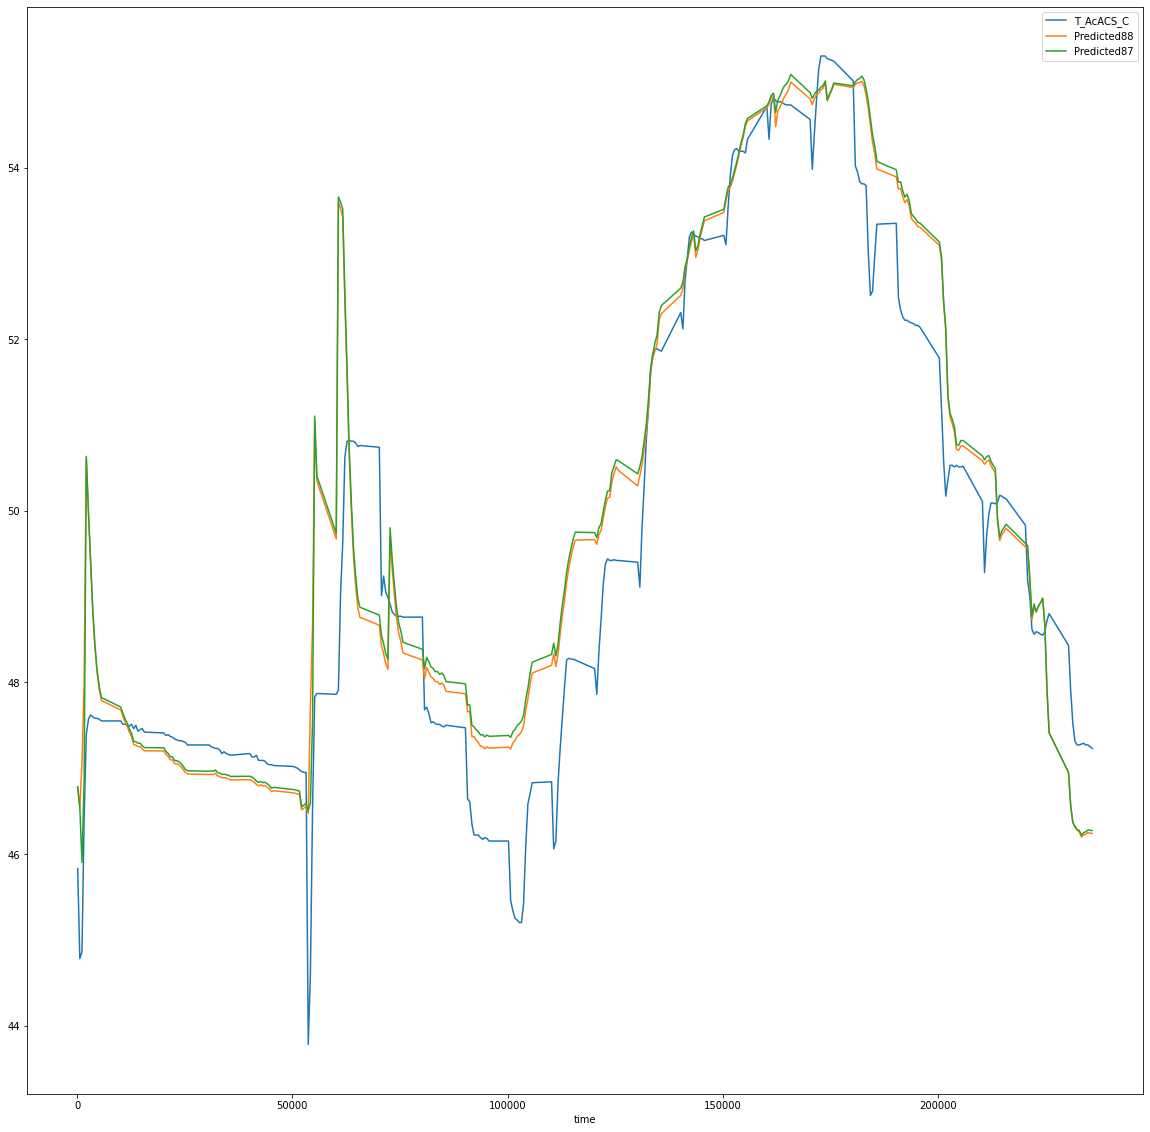

In [47]:
df[df['date']==20210901][['time','T_AcACS_C','Predicted88','Predicted87']].plot("time",figsize=DEFAULT_FIGSIZE)